# Bayesian Optimization of a Deoxyfluorination Reaction: 1-(6-nitrobenzo[d][1,3]dioxol-5-yl)ethan-1-ol

$CC(O)C1=C([N+]([O-])=O)C=C2C(OCO2)=C1$

Ben Shields & Jesus Martinez

## Build Reaction Space

Load DFT encoded component data and build the reaction space.

In [ ]:
# Imports

import pandas as pd
from edbo.utils import Data
from edbo.feature_utils import reaction_space

# Define reaction space components

# Load DFT descriptor CSV files computed with auto-qchem
sulfonyl_fluorides = Data(pd.read_csv('deoxyfluorination/descriptors/sulfonyl_fluoride_boltzmann_dft.csv'))
bases = Data(pd.read_csv('deoxyfluorination/descriptors/base_boltzmann_dft.csv'))
solvents = Data(pd.read_csv('deoxyfluorination/descriptors/solvent_dft.csv'))


# Remove some unwanted descriptors
for data in [sulfonyl_fluorides, bases, solvents]:
    data.drop(['file_name', 'entry', 'vibration', 'correlation', 'Rydberg', 
               'correction', 'atom_number', 'E-M_angle', 'MEAN', 'MAXG', 
               'STDEV'])

# Parameters in reaction space
components = {'sulfonyl_fluoride':'DFT',
              'base':'DFT',
              'solvent':'DFT',
              'substrate_concentration':[0.1, 0.2, 0.3, 0.4, 0.5],
              'sulfonyl_equiv':[1.1, 1.3, 1.5, 1.7, 1.9],
              'base_equiv':[1.1, 1.3, 1.5, 1.7, 1.9],
              'temperature':[20, 30, 40, 50, 60]}

# Encodings
encoding = {'substrate_concentration':'numeric',
            'sulfonyl_equiv':'numeric',
            'base_equiv':'numeric',
            'temperature':'numeric'}

# DFT descriptors
dft = {'sulfonyl_fluoride':sulfonyl_fluorides.data,
       'base':bases.data,
       'solvent':solvents.data}

# Encode reaction space

rxn = reaction_space(components, 
                     encoding=encoding, 
                     descriptor_matrices=dft, 
                     clean=True, 
                     decorrelate=True, 
                     decorrelation_threshold=0.95, 
                     standardize=True)

In [ ]:
rxn.base_data[rxn.index_headers]

In [ ]:
rxn.data.head()

In [ ]:
rxn.get_experiments([0,1,2,3,500])

In [ ]:
rxn.visualize(1000)

## Initialization

Use a random design.

In [ ]:
from edbo.bro import BO

# BO object
bo = BO(domain=rxn.data,                            # Encoded reaction space
        acquisition_function='EI',                  # Use expectation value of improvement
        init_method='rand',                         # Read in external data
        batch_size=5,                               # Experiments per round
        target='yield',                             # Optimize yield
        fast_comp=True)                             # Use gpytorch fast computation features

# Initialize
bo.init_sample(seed=8)
experiment_design = rxn.get_experiments(bo.proposed_experiments.index.values)

# Export design
experiment_design['yield'] = ['Add Results' for i in range(5)]
experiment_design.to_csv('results/init.csv')
bo.proposed_experiments.to_csv('results/init_encoded.csv')

experiment_design

Initialize Bayesian optimizer.

In [ ]:
from edbo.bro import BO

# BO object
bo = BO(domain=rxn.data,                            # Encoded reaction space
        acquisition_function='EI',                  # Use expectation value of improvement
        init_method='external',                     # Read in external data
        batch_size=5,                               # Experiments per round
        target='yield',                             # Optimize yield
        fast_comp=True)                             # Use gpytorch fast computation features

bo.reaction = rxn

Save optimizer instance for later.

In [ ]:
# Save instance for later

# bo.save(path='BO_benzylic.pkl')

## Bayesian Optimization

Load Bayesian optimizer.

In [2]:
from edbo.bro import BO

bo = BO()
bo.load(path='BO_benzylic.pkl')

Load experiment results.

In [3]:
import pandas as pd

################################################################################
################################################################################
result_paths = ['init_benzylic', 
                'round0_benzylic', 
                'round1_benzylic', 
                'round2_benzylic', 
                'round3_benzylic', 
                'round4_benzylic', 
                'round5_benzylic',
                'round6_benzylic',
                'round7_benzylic',
                'round8_benzylic'
               ]
base_path = 'results_benzylic/'
################################################################################
################################################################################

results = pd.DataFrame(columns=list(bo.obj.domain.columns.values) + ['yield'])
for path in result_paths:
    # Laod results
    result = pd.read_csv(base_path + path + '.csv', index_col=0)
    encoded = pd.read_csv(base_path + path + '_encoded.csv', index_col=0)
    
    # Get corresponding entries from domain
    points = bo.obj.domain.iloc[result.index.values].copy()
    
    # Check to make sure they are the same as the encoded
    if (points.values.round(5) == encoded.values.round(5)).all():
        points['yield'] = result['yield'].values
        results = pd.concat([results, points])
        
    else:
        print('\nError: Encoded log does not match selected points from BO.obj.domain...') 
        
results

,sulfonyl_fluoride_number_of_atoms_MING,sulfonyl_fluoride_dipole_MING,sulfonyl_fluoride_molar_mass_MING,sulfonyl_fluoride_molar_volume_MING,sulfonyl_fluoride_molar_volume_Boltz,sulfonyl_fluoride_electronic_spatial_extent_MING,sulfonyl_fluoride_homo_energy_MING,sulfonyl_fluoride_lumo_energy_MING,sulfonyl_fluoride_electronegativity_MING,sulfonyl_fluoride_hardness_MING,...,solvent_c_max_NMR_shift,solvent_c_max_ES_root_Mulliken_charge,solvent_c_max-1_Mulliken_charge,solvent_c_min+1_%VBur,solvent_c_max-1_%VBur,substrate_concentration,sulfonyl_equiv,base_equiv,temperature,yield
255709,0.428571,0.000000,0.317054,0.435961,0.181603,0.443185,0.457251,0.000000,1.000000,0.000000,...,0.452815,0.000000,0.000000,0.560205,1.000000,0.00,0.75,0.25,1.00,18
308173,0.571429,0.927693,0.098833,0.812444,0.335189,0.177133,0.854976,0.759082,0.250130,0.268511,...,0.160006,1.000000,0.762500,0.000000,0.492192,0.00,0.25,1.00,0.75,26
190130,0.571429,0.646497,0.098833,0.668101,0.287416,0.157251,1.000000,1.000000,0.000000,0.339939,...,0.452815,0.000000,0.000000,0.560205,1.000000,0.25,0.00,0.25,0.00,0
159500,0.142857,0.430908,0.633807,0.688925,0.214913,0.433115,0.734199,0.472127,0.514506,0.145303,...,0.053141,0.250087,1.000000,1.000000,0.337641,0.25,0.00,0.00,0.00,2
1117,0.571429,0.349792,0.479117,1.000000,0.574457,0.609048,0.580097,0.471442,0.614454,0.257885,...,1.000000,0.437067,0.975173,0.051338,0.000000,0.75,1.00,0.75,0.50,0
311374,0.571429,0.927693,0.098833,0.812444,0.335189,0.177133,0.854976,0.759082,0.250130,0.268511,...,0.160006,1.000000,0.762500,0.000000,0.492192,0.00,1.00,1.00,1.00,4
285649,0.571429,0.927693,0.098833,0.812444,0.335189,0.177133,0.854976,0.759082,0.250130,0.268511,...,0.000000,0.246203,0.768740,0.604231,0.107342,0.00,0.00,1.00,1.00,23
120649,0.000000,1.000000,0.006960,0.232963,0.000000,0.000000,0.643645,0.568540,0.510351,0.282931,...,0.160006,1.000000,0.762500,0.000000,0.492192,0.00,0.00,1.00,1.00,17
286850,0.571429,0.927693,0.098833,0.812444,0.335189,0.177133,0.854976,0.759082,0.250130,0.268511,...,0.160006,1.000000,0.762500,0.000000,0.492192,1.00,1.00,0.00,0.00,11
292504,0.571429,0.927693,0.098833,0.812444,0.335189,0.177133,0.854976,0.759082,0.250130,0.268511,...,0.160006,1.000000,0.762500,0.000000,0.492192,0.00,0.00,0.00,1.00,4


In [3]:
df = bo.reaction.get_experiments(results.index.values)
df['yield'] = results['yield'].copy()
df

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
255709,O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O,N12CCCN=C1NCCC2,C1CCOC1,0.1,1.7,1.3,60,18
308173,O=S(C1=CC=C(C)C=C1)(F)=O,CN1C2=NCCCN2CCC1,FC(C1=CC=CC=C1)(F)F,0.1,1.3,1.9,50,26
190130,O=S(CC1=CC=CC=C1)(F)=O,N1(CC2)CCC2CC1,C1CCOC1,0.2,1.1,1.3,20,0
159500,FC1=C(F)C(F)=C(S(=O)(F)=O)C(F)=C1F,N12CCCN=C1NCCC2,O=CN(C)C,0.2,1.1,1.1,20,2
1117,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,N1(CC2)CCC2CC1,O=S(C)C,0.4,1.9,1.7,40,0
311374,O=S(C1=CC=C(C)C=C1)(F)=O,CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3,FC(C1=CC=CC=C1)(F)F,0.1,1.9,1.9,60,4
285649,O=S(C1=CC=C(C)C=C1)(F)=O,N12CCCN=C1NCCC2,CC1=CC=CC=C1,0.1,1.1,1.9,60,23
120649,O=S(C1=CC=CC=N1)(F)=O,CN1C2=NCCCN2CCC1,FC(C1=CC=CC=C1)(F)F,0.1,1.1,1.9,60,17
286850,O=S(C1=CC=C(C)C=C1)(F)=O,N12CCCN=C1NCCC2,FC(C1=CC=CC=C1)(F)F,0.5,1.9,1.1,20,11
292504,O=S(C1=CC=C(C)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,FC(C1=CC=CC=C1)(F)F,0.1,1.1,1.1,60,4


In [4]:
df[df['sulfonyl_fluoride_SMILES_index'] == 'O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O']

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
245124,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,60,64
245604,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.5,1.9,1.1,60,27
245120,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,20,62
245024,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.1,1.9,60,45
223249,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,N12CCCN=C1NCCC2,CC1=CC=CC=C1,0.1,1.9,1.9,60,47
245624,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.5,1.9,1.9,60,37
245749,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,FC(C1=CC=CC=C1)(F)F,0.1,1.9,1.9,60,37
245123,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,50,36
244499,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,O=S(C)C,0.1,1.9,1.9,60,0
245119,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.7,60,60


Best result:


##################################################### Experiment

         sulfonyl_fluoride_SMILES_index          base_SMILES_index  \
11870  O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O  CN(/C(N(C)C)=N\C(C)(C)C)C   

      solvent_SMILES_index  substrate_concentration_index  \
11870  FC(C1=CC=CC=C1)(F)F                            0.5   

       sulfonyl_equiv_index  base_equiv_index  temperature_index  
11870                   1.9               1.9                 20   



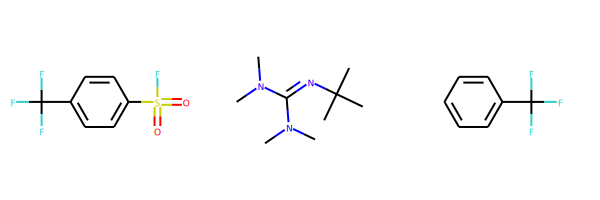

In [5]:
bo.reaction.visualize(df.sort_values('yield').index.values[-1])

Re-initialize data container with new data (will add a better method down the line).

In [6]:
from edbo.objective import objective

bo.obj = objective(domain=bo.obj.domain, results=results)

Run the optimizer.

In [7]:
bo.run()

,sulfonyl_fluoride_number_of_atoms_MING,sulfonyl_fluoride_dipole_MING,sulfonyl_fluoride_molar_mass_MING,sulfonyl_fluoride_molar_volume_MING,sulfonyl_fluoride_molar_volume_Boltz,sulfonyl_fluoride_electronic_spatial_extent_MING,sulfonyl_fluoride_homo_energy_MING,sulfonyl_fluoride_lumo_energy_MING,sulfonyl_fluoride_electronegativity_MING,sulfonyl_fluoride_hardness_MING,...,solvent_c_max_NPA_valence,solvent_c_max_NMR_shift,solvent_c_max_ES_root_Mulliken_charge,solvent_c_max-1_Mulliken_charge,solvent_c_min+1_%VBur,solvent_c_max-1_%VBur,substrate_concentration,sulfonyl_equiv,base_equiv,temperature
279995,0.428571,0.000000,0.317054,0.435961,0.181603,0.443185,0.457251,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.246203,0.76874,0.604231,0.107342,1.0,1.0,1.0,0.00
11871,0.571429,0.349792,0.479117,1.000000,0.574457,0.609048,0.580097,0.471442,0.614454,0.257885,...,0.528709,0.160006,1.000000,0.76250,0.000000,0.492192,1.0,1.0,1.0,0.25
261870,0.428571,0.000000,0.317054,0.435961,0.181603,0.443185,0.457251,0.000000,1.000000,0.000000,...,0.528709,0.160006,1.000000,0.76250,0.000000,0.492192,1.0,1.0,1.0,0.00
92499,0.142857,0.506440,0.242701,0.660928,0.321072,0.315793,0.785337,0.589331,0.405357,0.194299,...,0.000000,0.000000,0.246203,0.76874,0.604231,0.107342,1.0,1.0,1.0,1.00
261246,0.428571,0.000000,0.317054,0.435961,0.181603,0.443185,0.457251,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.246203,0.76874,0.604231,0.107342,1.0,1.0,1.0,0.25


Track progress.

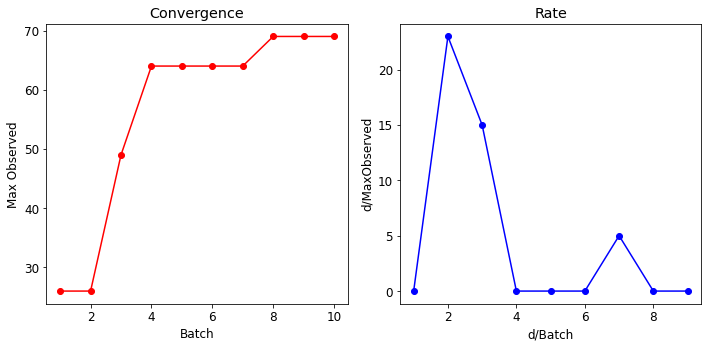

In [8]:
bo.plot_convergence()

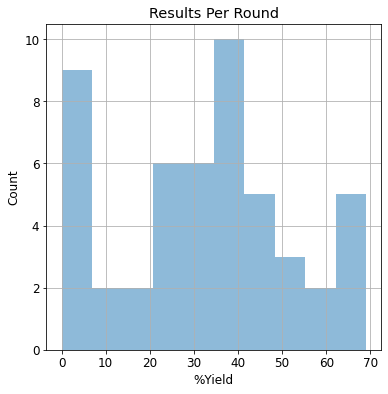

In [9]:
import matplotlib.pyplot as plt

bo.obj.results_input()['yield'].hist(alpha=0.5, figsize=(6,6))

plt.xlabel('%Yield')
plt.ylabel('Count')
plt.title('Results Per Round')
plt.show()

## Online Analysis

**Acquisition summary:** Summarize experiments seleced by acquisition function in terms of predicted mean and variance.

In [10]:
bo.acquisition_summary()

,sulfonyl_fluoride_number_of_atoms_MING,sulfonyl_fluoride_dipole_MING,sulfonyl_fluoride_molar_mass_MING,sulfonyl_fluoride_molar_volume_MING,sulfonyl_fluoride_molar_volume_Boltz,sulfonyl_fluoride_electronic_spatial_extent_MING,sulfonyl_fluoride_homo_energy_MING,sulfonyl_fluoride_lumo_energy_MING,sulfonyl_fluoride_electronegativity_MING,sulfonyl_fluoride_hardness_MING,...,solvent_c_max_ES_root_Mulliken_charge,solvent_c_max-1_Mulliken_charge,solvent_c_min+1_%VBur,solvent_c_max-1_%VBur,substrate_concentration,sulfonyl_equiv,base_equiv,temperature,predicted yield,variance
279995,0.428571,0.000000,0.317054,0.435961,0.181603,0.443185,0.457251,0.000000,1.000000,0.000000,...,0.246203,0.76874,0.604231,0.107342,1.0,1.0,1.0,0.00,46.092163,194.134827
11871,0.571429,0.349792,0.479117,1.000000,0.574457,0.609048,0.580097,0.471442,0.614454,0.257885,...,1.000000,0.76250,0.000000,0.492192,1.0,1.0,1.0,0.25,55.901009,68.911217
261870,0.428571,0.000000,0.317054,0.435961,0.181603,0.443185,0.457251,0.000000,1.000000,0.000000,...,1.000000,0.76250,0.000000,0.492192,1.0,1.0,1.0,0.00,44.872387,184.660446
92499,0.142857,0.506440,0.242701,0.660928,0.321072,0.315793,0.785337,0.589331,0.405357,0.194299,...,0.246203,0.76874,0.604231,0.107342,1.0,1.0,1.0,1.00,53.824966,82.805771
261246,0.428571,0.000000,0.317054,0.435961,0.181603,0.443185,0.457251,0.000000,1.000000,0.000000,...,0.246203,0.76874,0.604231,0.107342,1.0,1.0,1.0,0.25,56.477592,63.933002


**Acquisition function visualization:** Acquisition function values at each point in the domain.

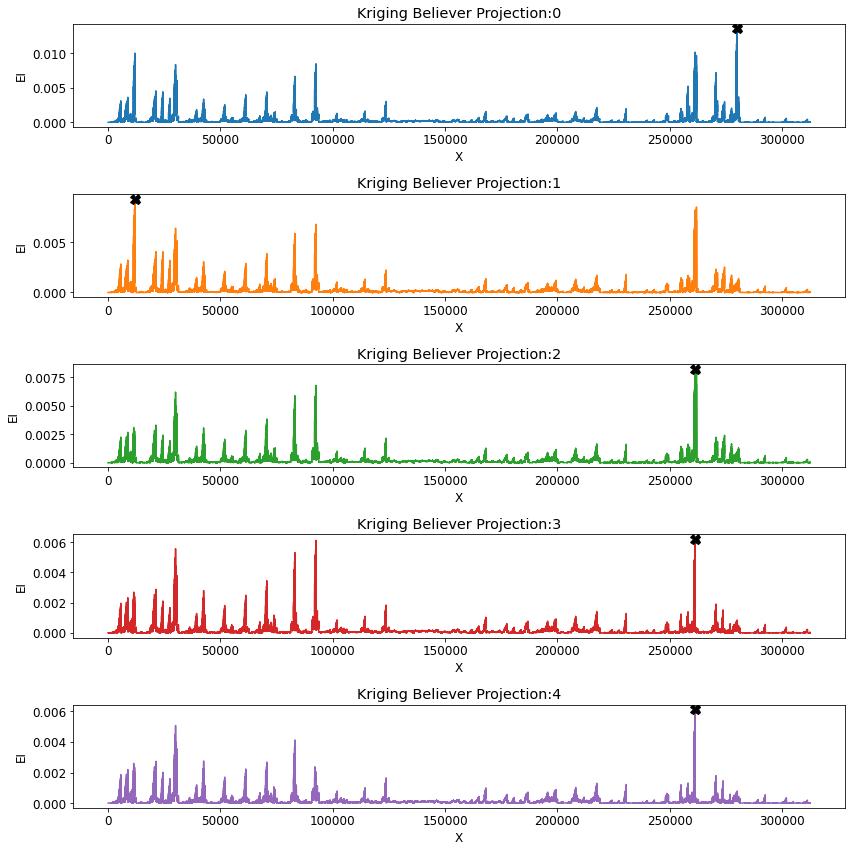

In [11]:
import numpy as np

fig, ax = plt.subplots(len(bo.acq.function.projections[:5]),1, figsize=(12, 12))
for i, p in enumerate(bo.acq.function.projections[:5]):
    ax[i].plot(range(len(p)), p, color='C' + str(i))
    ax[i].plot([np.argmax(p)], p[np.argmax(p)], 'X', markersize=10, color='black')
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('EI')
    ax[i].set_title('Kriging Believer Projection:' + str(i))
    
plt.tight_layout()
plt.show()

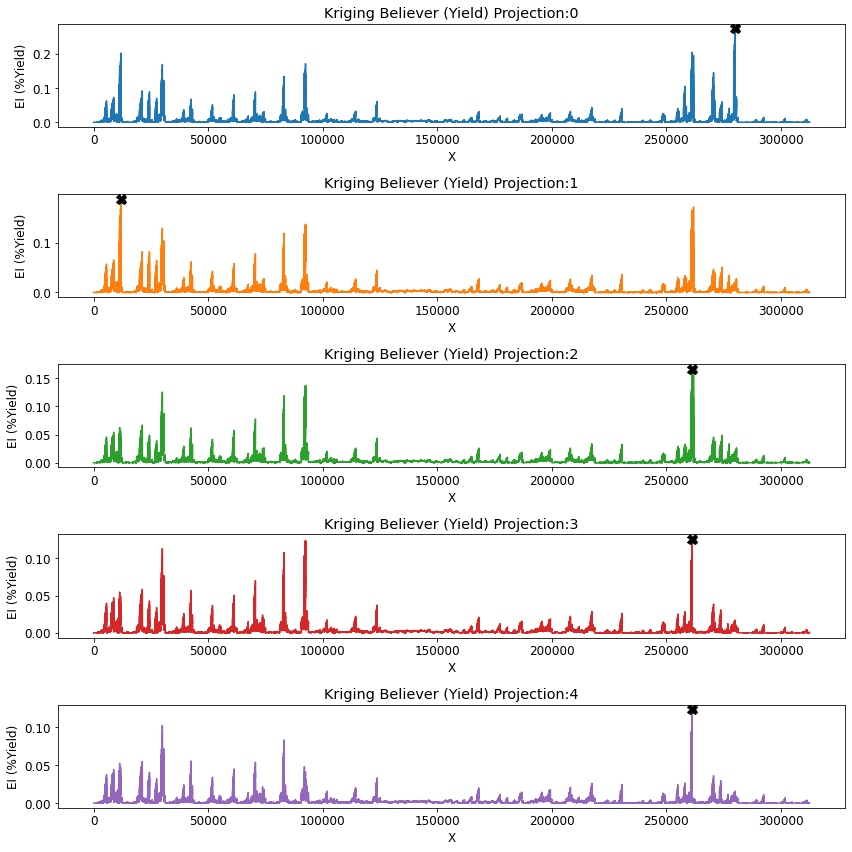

In [12]:
import numpy as np

fig, ax = plt.subplots(len(bo.acq.function.projections[:5]),1, figsize=(12, 12))
for i, p in enumerate(bo.acq.function.projections[:5]):
    ax[i].plot(range(len(p)), bo.obj.scaler.unstandardize(p) - bo.obj.scaler.mean, color='C' + str(i))
    ax[i].plot([np.argmax(p)], bo.obj.scaler.unstandardize(p)[np.argmax(p)] - bo.obj.scaler.mean, 'X', markersize=10, color='black')
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('EI (%Yield)')
    ax[i].set_title('Kriging Believer (Yield) Projection:' + str(i))
    
plt.tight_layout()
plt.show()

**Prediction Intervals (3 Sigma)**

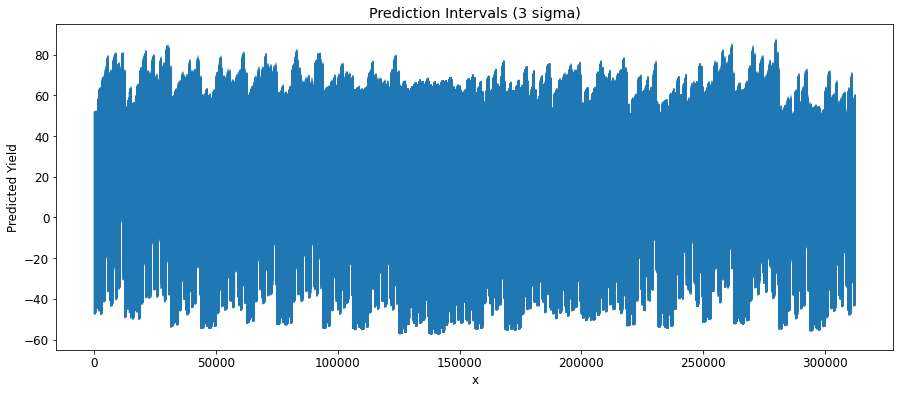

In [13]:
import numpy as np

mean = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
std = np.sqrt(bo.model.variance(bo.obj.domain)) * bo.obj.scaler.std * 3

plt.figure(figsize=(15,6))
plt.errorbar(range(len(mean)), mean, yerr=std, fmt='none', alpha=0.3, capsize=0)
plt.xlabel('x')
plt.ylabel('Predicted Yield')
plt.title('Prediction Intervals (3 sigma)')

plt.show()

**Surrogate model fit:** Model fit to all data.

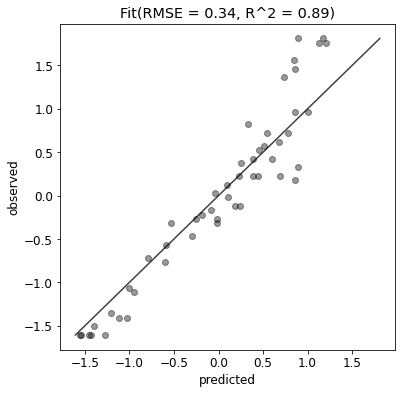

In [14]:
bo.model.regression()

**Surrogate model validation:** Model CV performance.

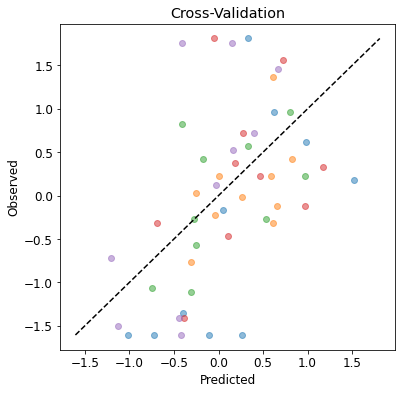

Mean Training RMSE      0.263243
Mean Validation RMSE    0.836846
Mean Training R^2       0.917895
Mean Validation R^2     0.156177
dtype: float64

In [15]:
from edbo.torch_utils import cv_split
from edbo.math_utils import model_performance
import numpy as np

NSPLITS = 5

split = cv_split(bo.model.X, n_splits=NSPLITS, random_state=0)
    
train = []
validation = []

plt.figure(figsize=(6,6))
plt.plot([bo.obj.y.min(), bo.obj.y.max()], [bo.obj.y.min(), bo.obj.y.max()], '--', color='black')
    
for train_index, test_index in split:
    
    X = bo.obj.X
    y = bo.obj.y
    
    # Initialize and train model
    model = bo.base_model(X[train_index],
                          y[train_index],
                          gpu=bo.gpu,
                          nu=bo.nu,
                          noise_constraint=bo.noise_constraint,
                          lengthscale_prior=bo.lengthscale_prior,
                          outputscale_prior=bo.outputscale_prior,
                          noise_prior=bo.noise_prior)
    model.fit()
        
    # Training performance
    fit = np.array(model.predict(X[train_index]))
    act = np.array(y[train_index])
    rmse_train, r2_train = model_performance(fit, act)
    train.append([rmse_train, r2_train])
        
    # Validation performance
    pred = np.array(model.predict(X[test_index]))
    obs = np.array(y[test_index])
    rmse_val, r2_val = model_performance(pred, obs)
    validation.append([rmse_val, r2_val])
    
    plt.scatter(pred, obs, alpha=0.5)

plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Cross-Validation')
plt.show()

pd.Series([np.array(train)[:,0].mean(),
           np.array(validation)[:,0].mean(),
           np.array(train)[:,1].mean(),
           np.array(validation)[:,1].mean()],
          index=['Mean Training RMSE', 'Mean Validation RMSE', 'Mean Training R^2', 'Mean Validation R^2'])

**Prediction & variance distributions:** Histograms for model predictions and standard deviation.

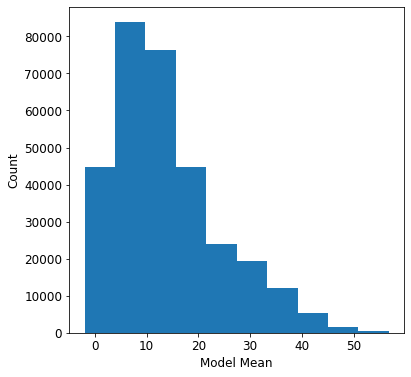

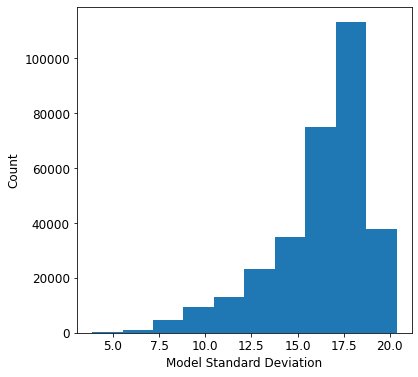

In [16]:
std = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))
plt.hist(std)
plt.xlabel('Model Mean')
plt.ylabel('Count')
plt.show()

std = np.sqrt(bo.model.variance(bo.obj.domain)) * bo.obj.scaler.std
plt.hist(std)
plt.xlabel('Model Standard Deviation')
plt.ylabel('Count')
plt.show()

**Feature importance:** Evaluate feature importance via learned length scales.

In [17]:
ls = pd.Series(bo.model.model.covar_module.base_kernel.lengthscale.detach().numpy()[0], 
               index=bo.obj.domain.columns.values).sort_values()

ls.head()

base_c_min+1_atom=C_MING    0.902048
solvent_ES3_osc_strength    1.336908
base_equiv                  2.097650
sulfonyl_equiv              4.239296
substrate_concentration     4.453279
dtype: float32

**Feature impact:** Function projections for most important parameters.

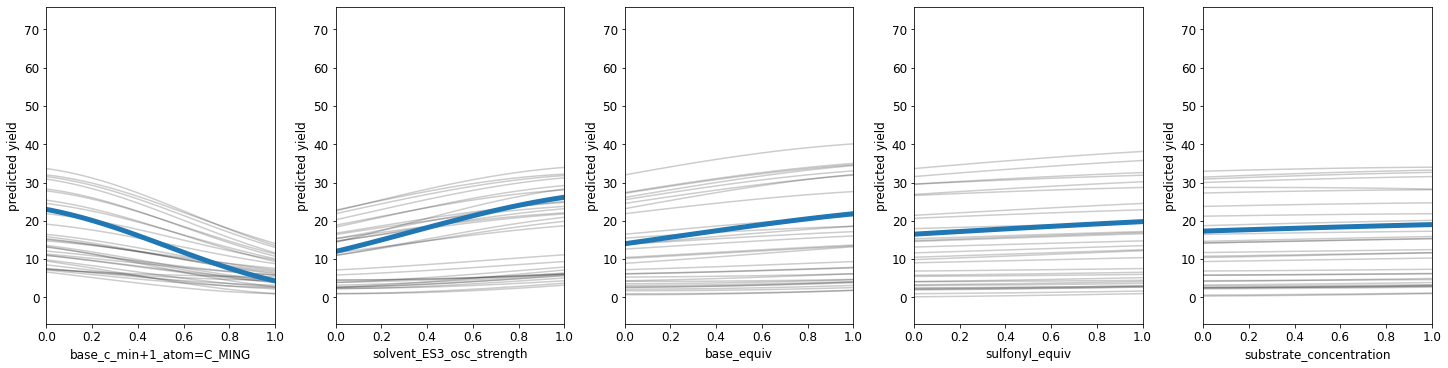

In [18]:
from edbo.plot_utils import dependence_plot

dependence_plot(bo, ls.index.values[:5], samples=30)

**Permutation importance**

In [111]:
from edbo.math_utils import model_performance

def perm_importance(bo, n_repeats=1):

    # Permutation features
    columns = bo.obj.results.drop('yield', axis=1).columns.values

    # True loss
    obs = bo.obj.results_input()['yield'].values
    true_pred = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.results.drop('yield', axis=1)))
    true_rmse, true_r2 = model_performance(true_pred, obs)

    # Repeat for statistics
    perm_results = pd.DataFrame(index=columns)
    for seed in range(n_repeats):

        # Permute
        loss_list = []
        for col in columns:
    
            # Copy data
            results_copy = bo.obj.results.copy().drop('yield', axis=1)
    
            # Random sample new column and replace
            new_col = results_copy[col].sample(len(results_copy), random_state=seed).values
            results_copy[col] = new_col
    
            # Compute loss
            perm_pred = bo.obj.scaler.unstandardize(bo.model.predict(results_copy))
            perm_rmse, perm_r2 = model_performance(perm_pred, obs)
            loss = true_rmse - perm_rmse
    
            loss_list.append(loss)

        perm = pd.Series(loss_list, index=columns, name='loss' + str(seed))
        perm_results=pd.concat([perm_results, perm], axis=1)
        
    means = perm_results.mean(axis=1)
    stds = perm_results.std(axis=1)
    summary = pd.concat([means, stds], axis=1).rename({0:'Mean', 1:'STD'}, axis='columns')

    summary['length scale'] = bo.model.model.covar_module.base_kernel.lengthscale.detach().numpy()[0]
    
    return perm_results, summary

perm_results, summary = perm_importance(bo, n_repeats=5)

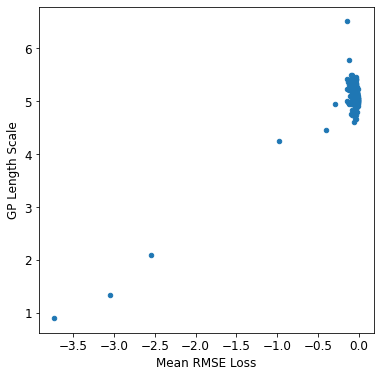

In [116]:
summary.plot.scatter('Mean', 'length scale')
plt.xlabel('Mean RMSE Loss')
plt.ylabel('GP Length Scale')
plt.show()

In [74]:
summary.sort_values('Mean').iloc[:10]

,Mean,STD,length scale
base_c_min+1_atom=C_MING,-3.737128,0.830679,0.902048
solvent_ES3_osc_strength,-3.051457,1.064049,1.336908
base_equiv,-2.550923,0.597132,2.097650
sulfonyl_equiv,-0.979790,0.120069,4.239296
substrate_concentration,-0.399832,0.138423,4.453279
base_c_max-1_atom=H_MING,-0.291698,0.132505,4.946286
base_ES5_osc_strength_MING,-0.149345,0.068994,4.999219
sulfonyl_fluoride_vib_3_standard_IR_intensity_Boltz,-0.147082,0.062445,5.237540
solvent_c_max_atom=C,-0.146015,0.032624,5.416747
temperature,-0.140510,0.054496,6.505151


***base_c_min+1_atom=C_MING***

This feature filters out the bases that only have a single nitrogen (which are all low yielding).

In [89]:
print(bo.reaction.base_data.iloc[results.index.values][['base_SMILES_index','base_c_min+1_atom=C_MING']].tail())

       base_SMILES_index  base_c_min+1_atom=C_MING
244499  CN1C2=NCCCN2CCC1                         0
298249           C1NCCC1                         1
1117      N1(CC2)CCC2CC1                         1
190130    N1(CC2)CCC2CC1                         1
232524         CCN(CC)CC                         1


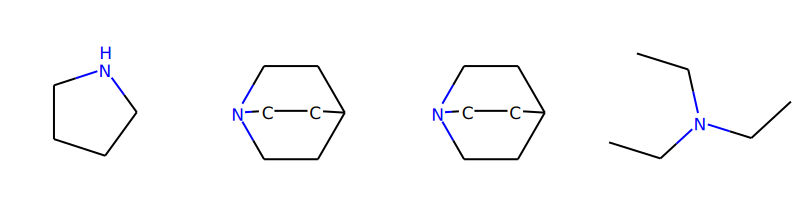

In [86]:
cdx = ChemDraw(bo.reaction.base_data.iloc[results.index.values]['base_SMILES_index'].iloc[-4:].values)
cdx.show()

***solvent_ES3_osc_strength**

This feature is highly correlated with molar volume and anticorrelated with hardness

In [94]:
bo.reaction.base_data.iloc[results.index.values].corr()['solvent_ES3_osc_strength'].sort_values()

solvent_hardness                 -0.894251
solvent_lumo_energy              -0.876850
solvent_c_max_NMR_shift          -0.800369
solvent_c_max_NPA_valence        -0.774352
solvent_ES1_osc_strength         -0.771653
                                    ...   
solvent_c_min+1_NMR_anisotropy    0.895718
solvent_number_of_atoms           0.903512
solvent_ES8_transition            0.907055
solvent_molar_volume              0.940020
solvent_ES3_osc_strength          1.000000
Name: solvent_ES3_osc_strength, Length: 263, dtype: float64

Less hard (more polarizable) solvents tend to work better.

In [108]:
des = bo.reaction.base_data.iloc[results.index.values].copy()
des['yield'] = results['yield']

des[['solvent_SMILES_index', 'solvent_hardness', 'yield']].sort_values('solvent_hardness').tail()

,solvent_SMILES_index,solvent_hardness,yield
159500,O=CN(C)C,0.137180,2
255709,C1CCOC1,0.162455,18
230749,C1CCOC1,0.162455,21
190130,C1CCOC1,0.162455,0
308774,C1CCOC1,0.162455,5


## Analysis of results

In [32]:
results = df.sort_values('yield', ascending=False)
results.iloc[:10]

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
11870,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,FC(C1=CC=CC=C1)(F)F,0.5,1.9,1.9,20,69
229399,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,60,69
261245,O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.5,1.9,1.9,20,68
92495,ClC1=CC=C(S(=O)(F)=O)C=C1,CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3,CC1=CC=CC=C1,0.5,1.9,1.9,20,68
245124,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,60,64
245120,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,20,62
245119,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.7,60,60
11145,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.5,1.1,1.9,20,52
229495,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.9,20,52
307624,O=S(C1=CC=C(C)C=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,60,49



Best Control:



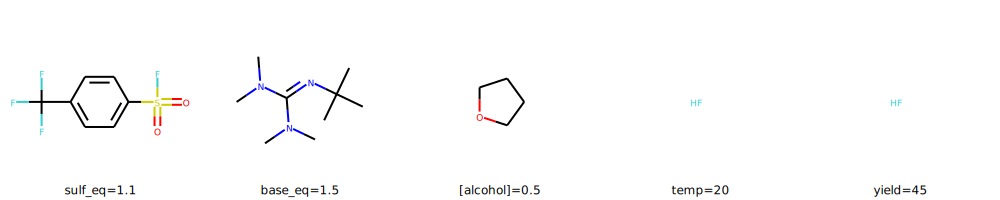


Optimization Results:



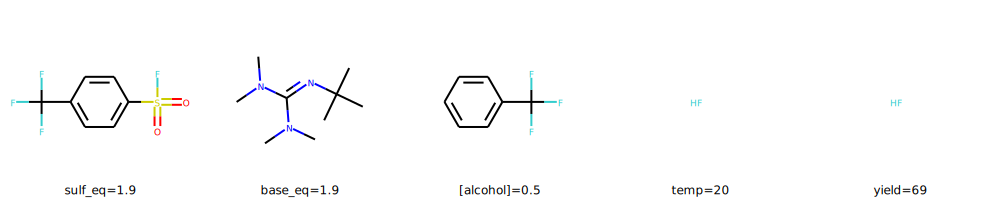

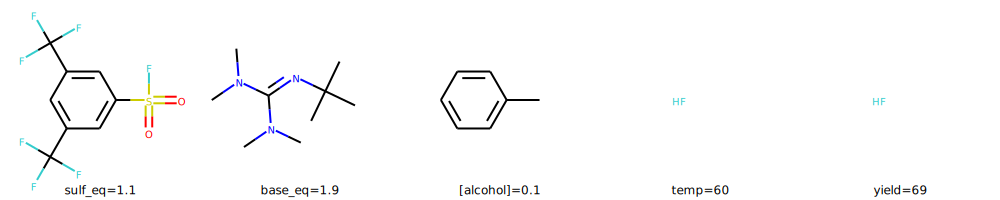

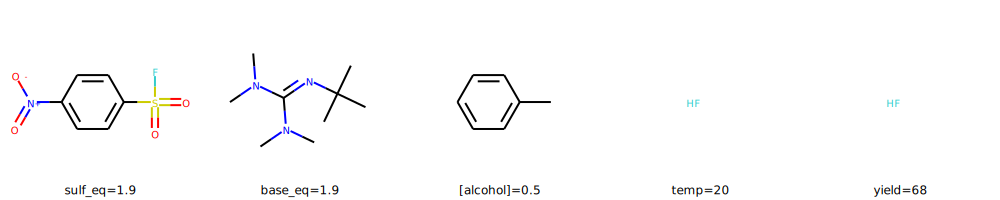

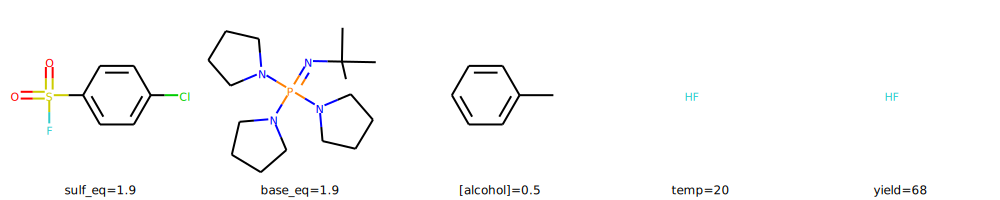

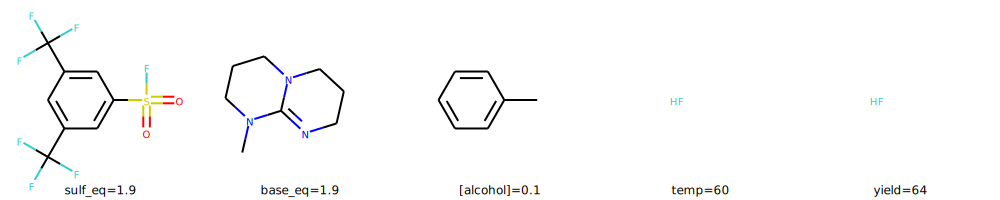

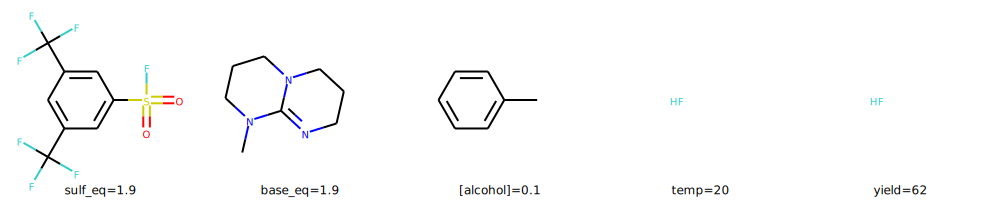

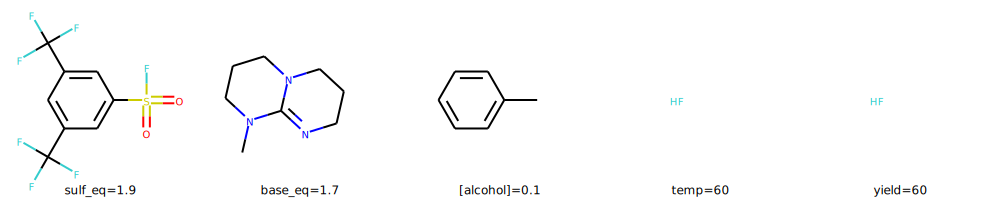

In [66]:
from edbo.chem_utils import ChemDraw

print('\nBest Control:\n')

row = np.array(['O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O',
                'CN(/C(N(C)C)=N\C(C)(C)C)C',
                'C1CCOC1', 
                0.5,
                1.1,
                1.5,
                20,
                45])

cdx = ChemDraw(list(row[:3]) + ['F', 'F'], legends=[n + '=' + str(c) for c, n in zip([row[4], row[5], row[3], row[6], row[7]], ['sulf_eq', 'base_eq', '[alcohol]', 'temp', 'yield'])])
cdx.show()

print('\nOptimization Results:\n')

for row in results.values[:7]:
    cdx = ChemDraw(list(row[:3]) + ['F', 'F'], legends=[n + '=' + str(c) for c, n in zip([row[4], row[5], row[3], row[6], row[7]], ['sulf_eq', 'base_eq', '[alcohol]', 'temp', 'yield'])])
    cdx.show()

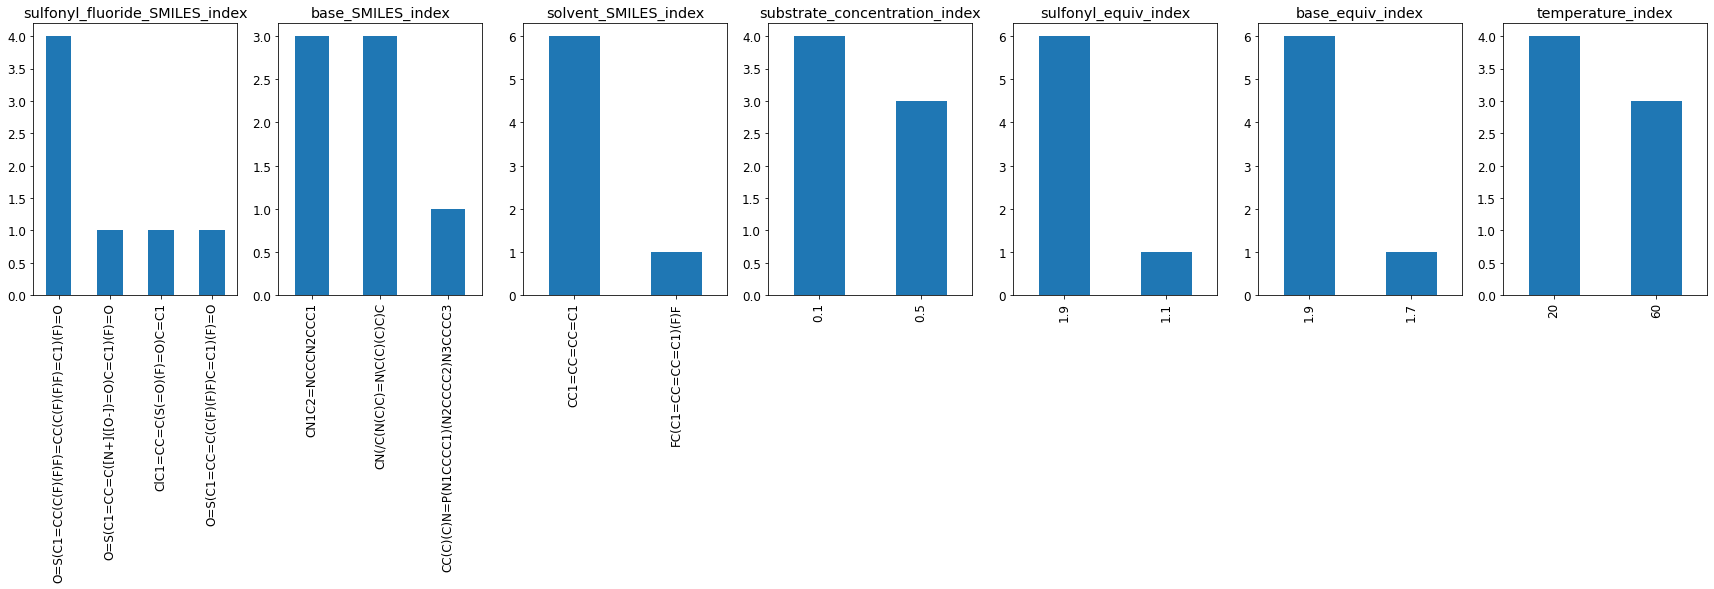

In [55]:
fig, ax = plt.subplots(1, len(results.columns.values[:-1]), figsize=(30,5))
for i, feature  in enumerate(results.columns.values[:-1]):
    results.iloc[:7][feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(feature)
plt.show()

## Next Round of Experiments

Export experiments to run for next round.

In [19]:
################################################################################
################################################################################
NAME = 'round8_benzylic'
################################################################################
################################################################################

import os.path

if os.path.isfile(base_path + NAME + '.csv') or os.path.isfile(base_path + NAME + '_encoded.csv'):
    print('Results file already exists. Choose a new name...')
else:
    expts = bo.reaction.get_experiments(bo.proposed_experiments.index.values)
    expts['yield'] = ['Add Results' for i in range(5)]
    expts.to_csv(base_path + NAME + '.csv')
    bo.proposed_experiments.to_csv(base_path + NAME + '_encoded.csv')

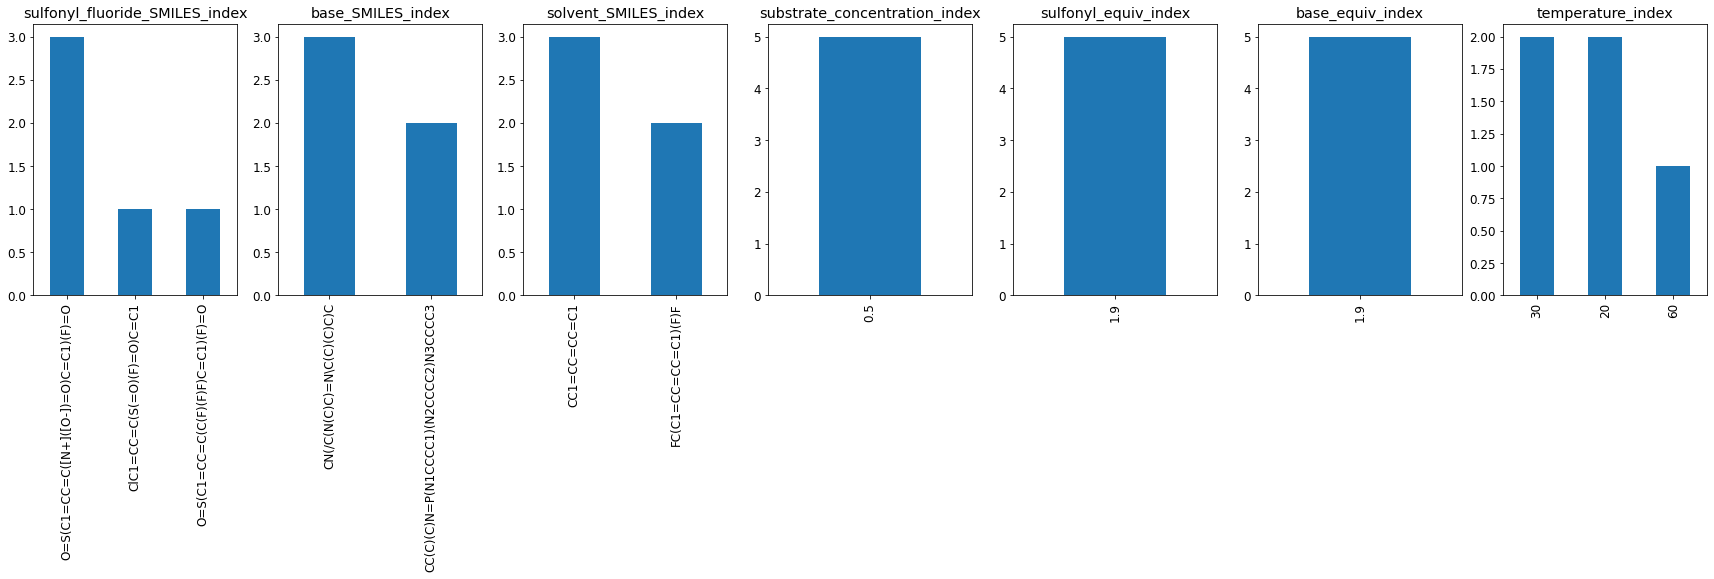

In [20]:
expts = bo.reaction.get_experiments(bo.proposed_experiments.index.values)

fig, ax = plt.subplots(1, len(expts.columns.values), figsize=(30,5))
for i, feature  in enumerate(expts.columns.values):
    expts[feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(feature)
plt.show()


Component: sulfonyl_fluoride_SMILES_index 



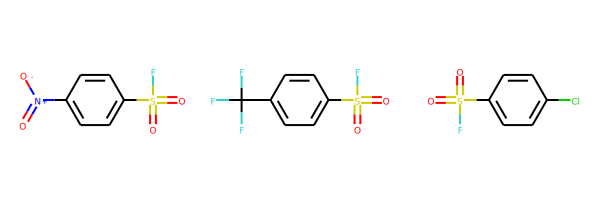


Component: base_SMILES_index 



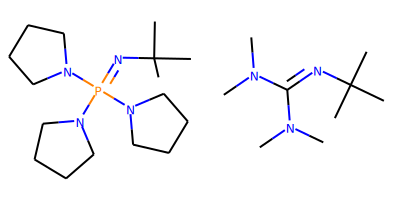


Component: solvent_SMILES_index 



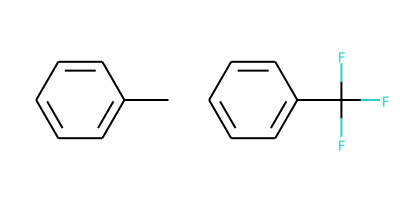

In [21]:
from edbo.chem_utils import ChemDraw

for col in expts.iloc[:,:3].columns.values:
    print('\nComponent:', col, '\n')
    cdx = ChemDraw(expts[col].drop_duplicates())
    cdx.show()

Sorted comparision with best sulfonyl fluoride and proposed experiments

In [22]:
pd.concat([df[df['sulfonyl_fluoride_SMILES_index'] == 'O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O'].reset_index(drop=True).copy(), 
           pd.concat([expts.copy().reset_index(drop=True), 
                      pd.DataFrame([['RUN'] for i in range(5)], columns=['yield'])], 
                     axis=1
                    ).iloc[[0,1,3]]
           ]).sort_values('base_SMILES_index')

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
3,ClC1=CC=C(S(=O)(F)=O)C=C1,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.5,1.1,1.9,20,RUN
13,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,41
1,ClC1=CC=C(S(=O)(F)=O)C=C1,CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3,CC1=CC=CC=C1,0.5,1.9,1.9,20,RUN
11,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CC(C)N1CCN2CCN(C(C)C)P1N(C(C)C)CC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,26
16,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CCN(CC)CC,CC1=CC=CC=C1,0.1,1.1,1.9,60,0
0,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.3,60,RUN
17,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,C1CCOC1,0.1,1.9,1.9,60,21
15,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,50,39
14,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,60,69
10,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.9,20,52


In [23]:
pd.concat([df[df['sulfonyl_fluoride_SMILES_index'] == 'O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O'].reset_index(drop=True).copy(), 
           pd.concat([expts.copy().reset_index(drop=True), 
                      pd.DataFrame([['RUN'] for i in range(5)], columns=['yield'])], 
                     axis=1
                    ).iloc[[0,1,3]]
           ]).sort_values('solvent_SMILES_index')

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
17,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,C1CCOC1,0.1,1.9,1.9,60,21
0,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,60,64
0,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.3,60,RUN
16,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CCN(CC)CC,CC1=CC=CC=C1,0.1,1.1,1.9,60,0
15,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,50,39
14,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,60,69
13,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,41
12,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.1,20,32
11,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CC(C)N1CCN2CCN(C(C)C)P1N(C(C)C)CC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,26
1,ClC1=CC=C(S(=O)(F)=O)C=C1,CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3,CC1=CC=CC=C1,0.5,1.9,1.9,20,RUN


In [24]:
pd.concat([df[df['sulfonyl_fluoride_SMILES_index'] == 'O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O'].reset_index(drop=True).copy(), 
           pd.concat([expts.copy().reset_index(drop=True), 
                      pd.DataFrame([['RUN'] for i in range(5)], columns=['yield'])], 
                     axis=1
                    ).iloc[[0,1,3]]
           ]).sort_values('substrate_concentration_index')

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
0,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,60,64
0,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.3,60,RUN
17,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,C1CCOC1,0.1,1.9,1.9,60,21
16,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CCN(CC)CC,CC1=CC=CC=C1,0.1,1.1,1.9,60,0
15,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,50,39
14,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,60,69
13,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,41
12,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.1,20,32
11,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CC(C)N1CCN2CCN(C(C)C)P1N(C(C)C)CC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,26
10,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.9,20,52


In [25]:
pd.concat([df[df['sulfonyl_fluoride_SMILES_index'] == 'O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O'].reset_index(drop=True).copy(), 
           pd.concat([expts.copy().reset_index(drop=True), 
                      pd.DataFrame([['RUN'] for i in range(5)], columns=['yield'])], 
                     axis=1
                    ).iloc[[0,1,3]]
           ]).sort_values('sulfonyl_equiv_index')

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
3,ClC1=CC=C(S(=O)(F)=O)C=C1,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.5,1.1,1.9,20,RUN
3,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.1,1.9,60,45
16,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CCN(CC)CC,CC1=CC=CC=C1,0.1,1.1,1.9,60,0
15,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,50,39
14,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,60,69
0,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.3,60,RUN
17,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,C1CCOC1,0.1,1.9,1.9,60,21
13,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,41
12,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.1,20,32
11,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CC(C)N1CCN2CCN(C(C)C)P1N(C(C)C)CC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,26


In [26]:
pd.concat([df[df['sulfonyl_fluoride_SMILES_index'] == 'O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O'].reset_index(drop=True).copy(), 
           pd.concat([expts.copy().reset_index(drop=True), 
                      pd.DataFrame([['RUN'] for i in range(5)], columns=['yield'])], 
                     axis=1
                    ).iloc[[0,1,3]]
           ]).sort_values('base_equiv_index')

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
1,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.5,1.9,1.1,60,27
12,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.1,20,32
0,O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.3,60,RUN
9,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.7,60,60
0,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,60,64
17,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,C1CCOC1,0.1,1.9,1.9,60,21
16,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CCN(CC)CC,CC1=CC=CC=C1,0.1,1.1,1.9,60,0
15,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,50,39
14,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,60,69
13,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,41


In [27]:
pd.concat([df[df['sulfonyl_fluoride_SMILES_index'] == 'O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O'].reset_index(drop=True).copy(), 
           pd.concat([expts.copy().reset_index(drop=True), 
                      pd.DataFrame([['RUN'] for i in range(5)], columns=['yield'])], 
                     axis=1
                    ).iloc[[0,1,3]]
           ]).sort_values('temperature_index')

,sulfonyl_fluoride_SMILES_index,base_SMILES_index,solvent_SMILES_index,substrate_concentration_index,sulfonyl_equiv_index,base_equiv_index,temperature_index,yield
10,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.9,1.9,20,52
13,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,41
12,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.1,20,32
11,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CC(C)N1CCN2CCN(C(C)C)P1N(C(C)C)CC2,CC1=CC=CC=C1,0.1,1.9,1.9,20,26
1,ClC1=CC=C(S(=O)(F)=O)C=C1,CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3,CC1=CC=CC=C1,0.5,1.9,1.9,20,RUN
3,ClC1=CC=C(S(=O)(F)=O)C=C1,C12=NCCCN1CCCCC2,CC1=CC=CC=C1,0.5,1.1,1.9,20,RUN
2,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,20,62
7,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,CC1=CC=CC=C1,0.1,1.9,1.9,50,36
15,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN(/C(N(C)C)=N\C(C)(C)C)C,CC1=CC=CC=C1,0.1,1.1,1.9,50,39
6,O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O,CN1C2=NCCCN2CCC1,FC(C1=CC=CC=C1)(F)F,0.1,1.9,1.9,60,37


In [10]:
for s in bo.reaction.descriptors['sulfonyl_fluoride'].data.iloc[:,0].values:
    print(s)

O=S(C1=CC=C(C(F)(F)F)C=C1)(F)=O
O=S(C1=CC=CC=C1)(F)=O
ClC1=CC=C(S(=O)(F)=O)C=C1
O=S(C1=CC=CC=N1)(F)=O
FC(C(F)(F)C(F)(F)S(=O)(F)=O)(F)C(F)(F)F
FC1=C(F)C(F)=C(S(=O)(F)=O)C(F)=C1F
O=S(CC1=CC=CC=C1)(F)=O
O=S(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)(F)=O
O=S(C1=CC=C([N+]([O-])=O)C=C1)(F)=O
O=S(C1=CC=C(C)C=C1)(F)=O


In [11]:
for s in bo.reaction.descriptors['base'].data.iloc[:,0].values:
    print(s)

N1(CC2)CCC2CC1
N12CCCN=C1NCCC2
CN1CCN2CCN(C)P1N(C)CC2
CN(/C(N(C)C)=N\C(C)(C)C)C
CCN(CC)CC
C1NCCC1
CC(C)N1CCN2CCN(C(C)C)P1N(C(C)C)CC2
C12=NCCCN1CCCCC2
CN1C2=NCCCN2CCC1
CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3


In [12]:
for s in bo.reaction.descriptors['solvent'].data.iloc[:,0].values:
    print(s)

O=CN(C)C
O=S(C)C
CC1=CC=CC=C1
FC(C1=CC=CC=C1)(F)F
C1CCOC1
